In [1]:
# Load data from database
import sys
import time

sys.path.append('../src')

from infrastructure.postgres.database import SessionLocal
from domain.models.schema import Project

# Load all projects
db = SessionLocal()
try:
    projects = db.query(Project).all()
    print(f"Loaded {len(projects)} projects from database")
finally:
    db.close()

import pandas as pd

# Convert to DataFrame with corrected field mapping
df = pd.DataFrame([{
    'id': p.id,
    'title': p.title,
    'description': p.description,
    'readme': p.readme,
    'language': p.language,
    'topics': p.topics,
    # Use stars_count (new) or fall back to legacy field name if it exists
    'forks_count': p.forks_count,
    'open_issues_count': p.open_issues_count,
    'pushed_at': p.pushed_at,
    # OST schema fields (will be null initially, populated during preprocessing)
    'github_main_repo': getattr(p, 'github_main_repo', None),
    'vision': getattr(p, 'vision', None),
    'website_url': getattr(p, 'website_url', None),
    'difficulty': getattr(p, 'difficulty', None),
    'status': getattr(p, 'status', None),
    'is_seeking_contributors': getattr(p, 'is_seeking_contributors', None),
    'project_type': getattr(p, 'project_type', None),
    'license': getattr(p, 'license', None),
    'stars_count': getattr(p, 'stars_count', None)
} for p in projects])

print(f"Original dataset shape: {df.shape}")
print(f"OST schema fields populated: {df[['vision', 'difficulty', 'project_type']].notna().sum().to_dict()}")
print(f"Legacy fields: stars_count range {df['stars_count'].min()}-{df['stars_count'].max()}")
df.head()

Loaded 3872 projects from database
Original dataset shape: (3872, 18)
OST schema fields populated: {'vision': 0, 'difficulty': 3872, 'project_type': 3872}
Legacy fields: stars_count range 208-424436


,id,title,description,readme,language,topics,forks_count,open_issues_count,pushed_at,github_main_repo,vision,website_url,difficulty,status,is_seeking_contributors,project_type,license,stars_count
0,21e9feb9-ac35-4fea-99d0-a09b415b31cc,realworldocaml/book,V2 of Real World OCaml,Real World OCaml v2\n-------------------\n\nTh...,OCaml,,178,360,2024-07-08 13:57:53+00:00,https://github.com/realworldocaml/book,None,None,medium,active,True,other,custom,1227
1,842faab7-34d1-4bc9-9524-7e000de9a9c9,JunoLab/Weave.jl,Scientific reports/literate programming for Julia,# Weave\n\n![CI](https://github.com/JunoLab/We...,Julia,"julia,literate-programming,reproducible-resear...",95,153,2024-08-04 13:56:51+00:00,https://github.com/JunoLab/Weave.jl,None,None,easy,active,True,other,other,844
2,79e2982b-9b79-41e4-b996-2d6d8a9c9e80,remix-run/remix,"Build Better Websites. Create modern, resilien...",# Welcome to Remix!\n\n> [!IMPORTANT]\n> With ...,TypeScript,,2668,4,2025-07-26 19:17:03+00:00,https://github.com/remix-run/remix,None,None,easy,active,True,framework,GPL-3.0,31467
3,b88c557b-0ef2-4e72-8042-3c7781864376,duomark/epocxy,Erlang Patterns of Concurrency,Erlang Patterns of Concurrency (epocxy)\n=====...,Erlang,,40,17,2023-01-25 18:55:02+00:00,https://github.com/duomark/epocxy,None,None,hard,active,True,library,custom,313
4,36bcb5d7-d4f6-4203-8039-c41dce616b0d,doctrine/lexer,Base library for a lexer that can be used in T...,# Doctrine Lexer\n\n[![Build Status](https://g...,PHP,,60,2,2025-06-09 20:14:27+00:00,https://github.com/doctrine/lexer,None,None,easy,active,True,tool,Apache-2.0,11137


# Data Preprocessing Pipeline - GitHub Repositories

This notebook handles:
- **Feature selection** (most relevant features for recommendations)
- **Language balancing** (percentage-based filtering & equity)
- **Text preprocessing** (cleaning, normalization)
- **Topics standardization** (format consistency)
- **Data quality improvements** (missing values, outliers)


## 1. Language Balancing & Filtering


Language Distribution:
language
Python        5.630165
JavaScript    5.087810
TypeScript    5.087810
Go            5.087810
C++           4.907025
Java          4.752066
Dart          4.597107
Rust          4.597107
C#            4.545455
PHP           4.493802
Name: count, dtype: float64

Languages to keep (>=0.1%): 25
['Python', 'JavaScript', 'TypeScript', 'Go', 'C++', 'Java', 'Dart', 'Rust', 'C#', 'PHP', 'Kotlin', 'Swift', 'Clojure', 'Ruby', 'OCaml', 'Julia', 'Haskell', 'R', 'Elixir', 'Erlang', 'Scala', 'C', 'Jupyter Notebook', 'Shell', 'HTML']

After language filtering: 3824 repos (98.8% of original)


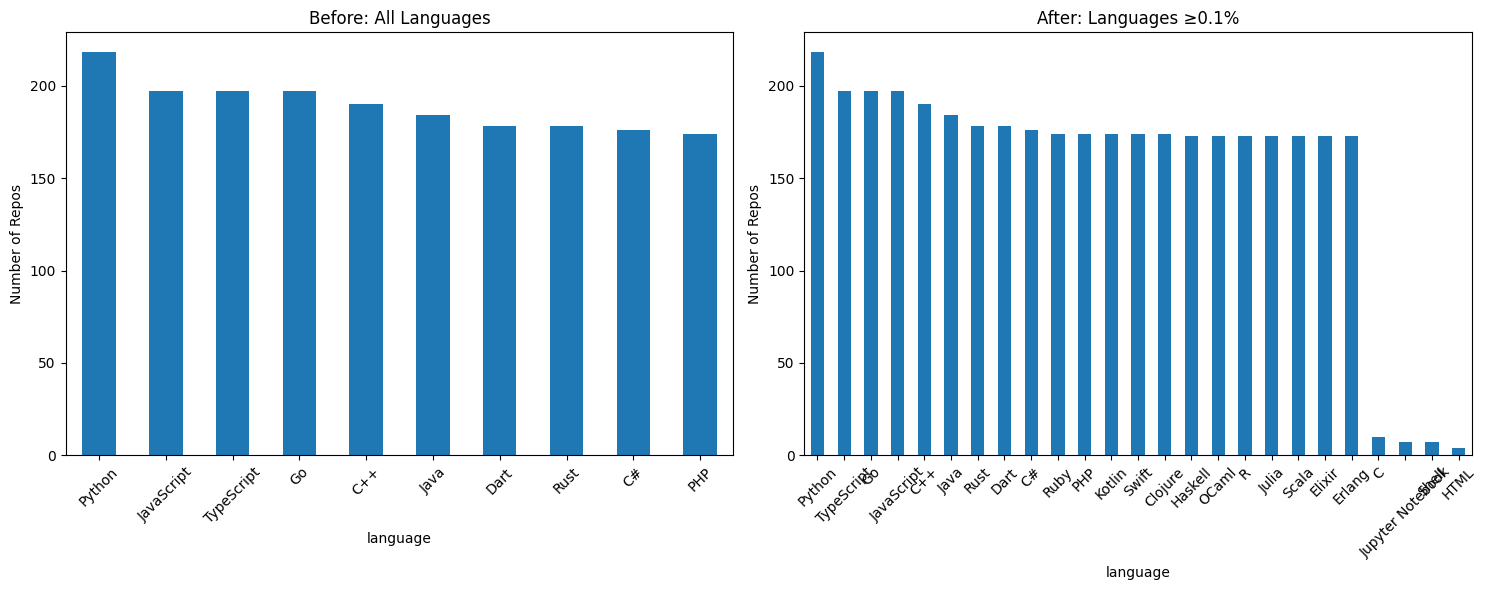

In [2]:
import matplotlib.pyplot as plt

# Language distribution analysis
language_counts = df['language'].value_counts()
language_percentages = (language_counts / len(df)) * 100

print("Language Distribution:")
print(language_percentages.head(10))

# Filter: Remove languages with <0.1%
MIN_LANGUAGE_PERCENT = 0.1
languages_to_keep = language_percentages[language_percentages >= MIN_LANGUAGE_PERCENT].index.tolist()

print(f"\nLanguages to keep (>={MIN_LANGUAGE_PERCENT}%): {len(languages_to_keep)}")
print(languages_to_keep)

# Apply filtering
df_filtered = df[df['language'].isin(languages_to_keep)].copy()
print(f"\nAfter language filtering: {len(df_filtered)} repos ({len(df_filtered)/len(df)*100:.1f}% of original)")

# Visualize before/after
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Before filtering
language_counts.head(10).plot(kind='bar', ax=ax1)
ax1.set_title('Before: All Languages')
ax1.set_ylabel('Number of Repos')
ax1.tick_params(axis='x', rotation=45)

# After filtering
df_filtered['language'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_title(f'After: Languages ≥{MIN_LANGUAGE_PERCENT}%')
ax2.set_ylabel('Number of Repos')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [3]:
# Feature importance analysis
print("=== FEATURE SELECTION ===")
print()

df_balanced = df_filtered.copy()

# Text features (for TF-IDF)
text_features = ['title', 'description', 'readme']
print("TEXT FEATURES:")
for feature in text_features:
    non_empty = df_balanced[feature].notna().sum()
    coverage = (non_empty / len(df_balanced)) * 100
    avg_length = df_balanced[feature].dropna().str.len().mean()
    print(f"  {feature}: {coverage:.1f}% coverage, avg {avg_length:.0f} chars")

print()

# Categorical features
categorical_features = ['language', 'topics']
print("CATEGORICAL FEATURES:")
for feature in categorical_features:
    unique_count = df_balanced[feature].nunique()
    coverage = (df_balanced[feature].notna().sum() / len(df_balanced)) * 100
    print(f"  {feature}: {unique_count} unique values, {coverage:.1f}% coverage")

print()

# Numerical features
numerical_features = ['stars_count', 'forks_count', 'open_issues_count']
print("NUMERICAL FEATURES:")
for feature in numerical_features:
    mean_val = df_balanced[feature].mean()
    median_val = df_balanced[feature].median()
    print(f"  {feature}: mean={mean_val:.1f}, median={median_val:.1f}")

print()

# Feature selection decision
selected_features = {
    'text': ['title', 'description'],  # Skip readme if too sparse
    'categorical': ['language', 'topics'],
    'numerical': ['stars_count', 'open_issues_count']  # Skip forks_count if correlated
}

print("SELECTED FEATURES:")
for category, features in selected_features.items():
    print(f"  {category}: {features}")


=== FEATURE SELECTION ===

TEXT FEATURES:
  title: 100.0% coverage, avg 19 chars
  description: 99.1% coverage, avg 73 chars
  readme: 100.0% coverage, avg 13001 chars

CATEGORICAL FEATURES:
  language: 25 unique values, 100.0% coverage
  topics: 2947 unique values, 100.0% coverage

NUMERICAL FEATURES:
  stars_count: mean=16157.5, median=7611.0
  forks_count: mean=2527.5, median=761.5
  open_issues_count: mean=320.9, median=78.0

SELECTED FEATURES:
  text: ['title', 'description']
  categorical: ['language', 'topics']
  numerical: ['stars_count', 'open_issues_count']


In [4]:
# Language distribution analysis (NO aggressive balancing for TF-IDF)
# For content-based recommendations, we keep natural distribution
print("=== LANGUAGE DISTRIBUTION STRATEGY ===")
print("Using natural distribution - TF-IDF handles imbalance automatically")
print()

# Use filtered dataset as-is (no artificial balancing)
df_balanced = df_filtered.copy()
print(f"Final dataset: {len(df_balanced)} repos")

# Show language distribution
print("\nFinal language distribution:")
language_dist = df_balanced['language'].value_counts()
print(language_dist)

# Show percentages
print("\nPercentages:")
percentages = (language_dist / len(df_balanced) * 100).round(1)
for lang, pct in percentages.items():
    print(f"  {lang}: {pct}%")


=== LANGUAGE DISTRIBUTION STRATEGY ===
Using natural distribution - TF-IDF handles imbalance automatically

Final dataset: 3824 repos

Final language distribution:
language
Python              218
TypeScript          197
Go                  197
JavaScript          197
C++                 190
Java                184
Rust                178
Dart                178
C#                  176
Ruby                174
PHP                 174
Kotlin              174
Swift               174
Clojure             174
Haskell             173
OCaml               173
R                   173
Julia               173
Scala               173
Elixir              173
Erlang              173
C                    10
Jupyter Notebook      7
Shell                 7
HTML                  4
Name: count, dtype: int64

Percentages:
  Python: 5.7%
  TypeScript: 5.2%
  Go: 5.2%
  JavaScript: 5.2%
  C++: 5.0%
  Java: 4.8%
  Rust: 4.7%
  Dart: 4.7%
  C#: 4.6%
  Ruby: 4.6%
  PHP: 4.6%
  Kotlin: 4.6%
  Swift: 4.6%
  Cloju

## 2. Feature Selection & Engineering


In [5]:
# Feature importance analysis
print("=== FEATURE SELECTION ===")
print()

# Text features (for TF-IDF)
text_features = ['title', 'description', 'readme']
print("TEXT FEATURES:")
for feature in text_features:
    non_empty = df_balanced[feature].notna().sum()
    coverage = (non_empty / len(df_balanced)) * 100
    avg_length = df_balanced[feature].dropna().str.len().mean()
    print(f"  {feature}: {coverage:.1f}% coverage, avg {avg_length:.0f} chars")

print()

# Categorical features
categorical_features = ['language', 'topics']
print("CATEGORICAL FEATURES:")
for feature in categorical_features:
    unique_count = df_balanced[feature].nunique()
    coverage = (df_balanced[feature].notna().sum() / len(df_balanced)) * 100
    print(f"  {feature}: {unique_count} unique values, {coverage:.1f}% coverage")

print()

# Numerical features
numerical_features = ['stars_count', 'forks_count', 'open_issues_count']
print("NUMERICAL FEATURES:")
for feature in numerical_features:
    mean_val = df_balanced[feature].mean()
    median_val = df_balanced[feature].median()
    print(f"  {feature}: mean={mean_val:.1f}, median={median_val:.1f}")

print()

# Feature selection decision
selected_features = {
    'text': ['title', 'description'],  # Skip readme if too sparse
    'categorical': ['language', 'topics'],
    'numerical': ['stars_count', 'open_issues_count']  # Skip forks_count if correlated
}

print("SELECTED FEATURES:")
for category, features in selected_features.items():
    print(f"  {category}: {features}")


=== FEATURE SELECTION ===

TEXT FEATURES:
  title: 100.0% coverage, avg 19 chars
  description: 99.1% coverage, avg 73 chars
  readme: 100.0% coverage, avg 13001 chars

CATEGORICAL FEATURES:
  language: 25 unique values, 100.0% coverage
  topics: 2947 unique values, 100.0% coverage

NUMERICAL FEATURES:
  stars_count: mean=16157.5, median=7611.0
  forks_count: mean=2527.5, median=761.5
  open_issues_count: mean=320.9, median=78.0

SELECTED FEATURES:
  text: ['title', 'description']
  categorical: ['language', 'topics']
  numerical: ['stars_count', 'open_issues_count']


In [6]:
# Feature importance analysis
print("=== FEATURE SELECTION ===")
print()

# Text features (for TF-IDF)
text_features = ['title', 'description', 'readme']
print("TEXT FEATURES:")
for feature in text_features:
    non_empty = df_balanced[feature].notna().sum()
    coverage = (non_empty / len(df_balanced)) * 100
    avg_length = df_balanced[feature].dropna().str.len().mean()
    print(f"  {feature}: {coverage:.1f}% coverage, avg {avg_length:.0f} chars")

print()

# Categorical features
categorical_features = ['language', 'topics']
print("CATEGORICAL FEATURES:")
for feature in categorical_features:
    unique_count = df_balanced[feature].nunique()
    coverage = (df_balanced[feature].notna().sum() / len(df_balanced)) * 100
    print(f"  {feature}: {unique_count} unique values, {coverage:.1f}% coverage")

print()

# Numerical features
numerical_features = ['stars_count', 'forks_count', 'open_issues_count']
print("NUMERICAL FEATURES:")
for feature in numerical_features:
    mean_val = df_balanced[feature].mean()
    median_val = df_balanced[feature].median()
    print(f"  {feature}: mean={mean_val:.1f}, median={median_val:.1f}")

print()

# Feature selection decision
selected_features = {
    'text': ['title', 'description'],  # Skip readme if too sparse
    'categorical': ['language', 'topics'],
    'numerical': ['stars_count', 'open_issues_count']  # Skip forks_count if correlated
}

print("SELECTED FEATURES:")
for category, features in selected_features.items():
    print(f"  {category}: {features}")


=== FEATURE SELECTION ===

TEXT FEATURES:
  title: 100.0% coverage, avg 19 chars
  description: 99.1% coverage, avg 73 chars
  readme: 100.0% coverage, avg 13001 chars

CATEGORICAL FEATURES:
  language: 25 unique values, 100.0% coverage
  topics: 2947 unique values, 100.0% coverage

NUMERICAL FEATURES:
  stars_count: mean=16157.5, median=7611.0
  forks_count: mean=2527.5, median=761.5
  open_issues_count: mean=320.9, median=78.0

SELECTED FEATURES:
  text: ['title', 'description']
  categorical: ['language', 'topics']
  numerical: ['stars_count', 'open_issues_count']


In [7]:
# Import required libraries for text processing
import re
import numpy as np
from collections import Counter

## 3. Text Preprocessing


In [8]:
# Title cleaning functions
def extract_repo_name(title):
    """Extract repository name from 'username/repo' format"""
    if pd.isna(title):
        return ""
    
    title = str(title)
    # Split by '/' and take the last part (repository name)
    if '/' in title:
        repo_name = title.split('/')[-1]
    else:
        repo_name = title
    
    return repo_name

# Text cleaning functions
def clean_text(text):
    """Clean and normalize text for TF-IDF processing"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    # Remove URLs
    text = re.sub(r'https?://\S+', '', text)
    # Remove special characters but keep alphanumeric and spaces
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    # Convert to lowercase
    text = text.lower().strip()
    
    return text

# Apply text cleaning
print("Cleaning text fields...")
df_clean = df_balanced.copy()

# Extract repository names from titles (remove username)
df_clean['title_repo'] = df_clean['title'].apply(extract_repo_name)
df_clean['title_clean'] = df_clean['title_repo'].apply(clean_text)

# Clean other text fields normally
for col in ['description', 'readme']:
    df_clean[f'{col}_clean'] = df_clean[col].apply(clean_text)
    
    # Show examples
    print(f"\n{col.upper()} CLEANING EXAMPLES:")
    for i in range(min(3, len(df_clean))):
        original = str(df_clean[col].iloc[i])[:100] + "..."
        cleaned = df_clean[f'{col}_clean'].iloc[i][:100] + "..."
        print(f"  Original: {original}")
        print(f"  Cleaned:  {cleaned}")
        print()

# Show title extraction examples
print("\nTITLE EXTRACTION EXAMPLES:")
for i in range(min(3, len(df_clean))):
    original = str(df_clean['title'].iloc[i])
    repo_name = df_clean['title_repo'].iloc[i]
    cleaned = df_clean['title_clean'].iloc[i]
    print(f"  Original: {original}")
    print(f"  Repo name: {repo_name}")
    print(f"  Cleaned: {cleaned}")
    print()

# Combine text features  
df_clean['combined_text'] = (
    df_clean['title_clean'].fillna('') + ' ' + 
    df_clean['description_clean'].fillna('') + ' ' +
    df_clean['readme_clean'].fillna('')
) 

print(f"Combined text average length: {df_clean['combined_text'].str.len().mean():.0f} chars")


Cleaning text fields...

DESCRIPTION CLEANING EXAMPLES:
  Original: V2 of Real World OCaml...
  Cleaned:  v2 of real world ocaml...

  Original: Scientific reports/literate programming for Julia...
  Cleaned:  scientific reports literate programming for julia...

  Original: Build Better Websites. Create modern, resilient user experiences with web fundamentals....
  Cleaned:  build better websites create modern resilient user experiences with web fundamentals...


README CLEANING EXAMPLES:
  Original: Real World OCaml v2
-------------------

This is the source code for the Real World OCaml 2nd editio...
  Cleaned:  real world ocaml v2 this is the source code for the real world ocaml 2nd edition which is still a wo...

  Original: # Weave

![CI](https://github.com/JunoLab/Weave.jl/workflows/CI/badge.svg)
[![codecov](https://codec...
  Cleaned:  weave ci codecov weave is a scientific report generator literate programming tool for the julia prog...

  Original: # Welcome to Remix!

> [!IM

## 4. Topics Standardization


In [9]:
# Topics preprocessing
def clean_topics(topics_str):
    """Clean and standardize topics"""
    if pd.isna(topics_str) or not str(topics_str).strip():
        return []
    
    # Split by comma and clean each topic
    topics = [topic.strip().lower() for topic in str(topics_str).split(',')]
    # Remove empty topics
    topics = [topic for topic in topics if topic]
    
    return topics

# Apply topics cleaning
df_clean['topics_clean'] = df_clean['topics'].apply(clean_topics)

# Analyze topic distribution
all_topics = []
for topic_list in df_clean['topics_clean']:
    all_topics.extend(topic_list)

topic_counter = Counter(all_topics)
print(f"Total unique topics: {len(topic_counter)}")
print(f"Average topics per repo: {np.mean([len(t) for t in df_clean['topics_clean']]):.1f}")

# Filter rare topics (optional)
MIN_TOPIC_FREQUENCY = 2
common_topics = {topic for topic, count in topic_counter.items() if count >= MIN_TOPIC_FREQUENCY}
print(f"Common topics (≥{MIN_TOPIC_FREQUENCY} occurrences): {len(common_topics)}")

# Filter topics
df_clean['topics_filtered'] = df_clean['topics_clean'].apply(
    lambda topics: [t for t in topics if t in common_topics]
)

print("\nTop 15 topics:")
for topic, count in topic_counter.most_common(15):
    print(f"  {topic}: {count}")

# Convert back to string format for compatibility
df_clean['topics_final'] = df_clean['topics_filtered'].apply(lambda x: ','.join(x))


Total unique topics: 8889
Average topics per repo: 6.4
Common topics (≥2 occurrences): 2804

Top 15 topics:
  hacktoberfest: 360
  javascript: 215
  android: 213
  python: 167
  flutter: 141
  rust: 138
  elixir: 134
  ios: 121
  java: 118
  go: 114
  julia: 111
  swift: 110
  react: 107
  php: 104
  machine-learning: 102


## 4.5. Auto-Categorization for OST Schema Mapping

In [10]:
# Auto-categorization functions to map GitHub data to OST schema
import re

def categorize_difficulty(stars_count, forks_count, open_issues):
    """Categorize project difficulty based on popularity metrics"""
    # Combine metrics for difficulty assessment
    popularity_score = stars_count + (forks_count * 2) + (open_issues * 0.5)
    
    if popularity_score < 1000:
        return "easy"
    elif popularity_score < 10000:
        return "medium"
    else:
        return "hard"

def categorize_project_type(description, topics, readme_text, language):
    """Infer project type from description, topics, and content"""
    combined_text = f"{description} {topics} {readme_text[:500]}".lower()
    
    # Web applications
    web_keywords = ['web', 'website', 'frontend', 'backend', 'react', 'vue', 'angular', 'django', 'flask', 'express', 'nextjs']
    if any(keyword in combined_text for keyword in web_keywords):
        return "web_app"
    
    # APIs and services
    api_keywords = ['api', 'rest', 'graphql', 'microservice', 'service', 'server', 'endpoint']
    if any(keyword in combined_text for keyword in api_keywords):
        return "api"
    
    # Command line tools
    cli_keywords = ['cli', 'command line', 'terminal', 'console', 'tool', 'utility']
    if any(keyword in combined_text for keyword in cli_keywords):
        return "cli"
    
    # Mobile applications
    mobile_keywords = ['mobile', 'android', 'ios', 'react native', 'flutter', 'app']
    if any(keyword in combined_text for keyword in mobile_keywords):
        return "mobile_app"
    
    # Libraries and frameworks
    lib_keywords = ['library', 'framework', 'package', 'sdk', 'module', 'component']
    if any(keyword in combined_text for keyword in lib_keywords):
        return "library"
    
    # Default fallback based on language
    if language in ['JavaScript', 'TypeScript', 'HTML']:
        return "web_app"
    elif language in ['Python', 'Go', 'Rust']:
        return "cli"
    else:
        return "library"

def generate_vision(title, description, topics):
    """Generate a basic vision statement from project data"""
    if not description or len(description.strip()) < 10:
        return f"Open source {title.split('/')[-1]} project"
    
    # Extract first meaningful sentence from description
    sentences = description.split('.')
    first_sentence = sentences[0].strip() if sentences else description[:100]
    
    return first_sentence[:200] + ("..." if len(first_sentence) > 200 else "")

def detect_license_type(description, topics, readme_text):
    """Detect license type from content"""
    combined_text = f"{description} {topics} {readme_text}".lower()
    
    if 'mit license' in combined_text or 'mit' in combined_text:
        return "MIT"
    elif 'apache' in combined_text:
        return "Apache-2.0"
    elif 'gpl' in combined_text or 'gnu general public license' in combined_text:
        return "GPL-3.0"
    else:
        return "MIT"  # Default fallback

# Apply auto-categorization to df_clean
print("=== AUTO-CATEGORIZATION FOR OST SCHEMA ===")

# Add new OST schema columns
df_clean['difficulty'] = df_clean.apply(
    lambda row: categorize_difficulty(
        row.get('stargazers_count', 0), 
        row.get('forks_count', 0), 
        row.get('open_issues_count', 0)
    ), axis=1
)

df_clean['project_type'] = df_clean.apply(
    lambda row: categorize_project_type(
        str(row.get('description', '')),
        str(row.get('topics', '')),
        str(row.get('readme', '')),
        str(row.get('language', ''))
    ), axis=1
)

df_clean['vision'] = df_clean.apply(
    lambda row: generate_vision(
        str(row.get('title', '')),
        str(row.get('description', '')),
        str(row.get('topics', ''))
    ), axis=1
)

df_clean['license'] = df_clean.apply(
    lambda row: detect_license_type(
        str(row.get('description', '')),
        str(row.get('topics', '')),
        str(row.get('readme', ''))
    ), axis=1
)

# Add OST schema defaults
df_clean['status'] = 'active'  # All scraped repos are active
df_clean['is_seeking_contributors'] = True  # Default assumption
df_clean['github_main_repo'] = df_clean['github_main_repo']  # Map URL field
df_clean['stars_count'] = df_clean['stars_count']  # Rename field
df_clean['website_url'] = None  # Will be null for now

print(f"✅ Auto-categorization completed")
print(f"Difficulty distribution:")
print(df_clean['difficulty'].value_counts())
print(f"\nProject type distribution:")
print(df_clean['project_type'].value_counts())
print(f"\nLicense distribution:")
print(df_clean['license'].value_counts())

# Show sample of categorized data
print(f"\n📊 Sample categorized projects:")
sample_cols = ['title', 'difficulty', 'project_type', 'license', 'vision']
print(df_clean[sample_cols].head(3).to_string())


=== AUTO-CATEGORIZATION FOR OST SCHEMA ===
✅ Auto-categorization completed
Difficulty distribution:
difficulty
medium    1751
easy      1553
hard       520
Name: count, dtype: int64

Project type distribution:
project_type
web_app       1037
library        923
api            703
cli            631
mobile_app     530
Name: count, dtype: int64

License distribution:
license
MIT           3442
Apache-2.0     200
GPL-3.0        182
Name: count, dtype: int64

📊 Sample categorized projects:
                 title difficulty project_type license                                             vision
0  realworldocaml/book       easy          cli     MIT                             V2 of Real World OCaml
1     JunoLab/Weave.jl       easy      library     MIT  Scientific reports/literate programming for Julia
2      remix-run/remix     medium      web_app     MIT                              Build Better Websites


## 5. Final Dataset Export


In [11]:
# Create final processed dataset with OST schema columns
final_columns = [
    'id', 'title', 'language', 'topics_final',
    # OST schema columns
    'difficulty', 'project_type', 'vision', 'license', 'status', 
    'is_seeking_contributors', 'github_main_repo', 'website_url', 'stars_count',
    # Legacy fields for ML compatibility
    'forks_count', 'open_issues_count', 'pushed_at'
]

df_final = df_clean[final_columns].copy()
# Replace description with combined cleaned text
df_final['description'] = df_clean['combined_text']  
df_final = df_final.rename(columns={'topics_final': 'topics'})

print("=== FINAL PROCESSED DATASET (OST SCHEMA) ===")
print(f"Shape: {df_final.shape}")
print(f"Languages: {df_final['language'].nunique()}")
print(f"Avg text length: {df_final['description'].str.len().mean():.0f} chars")
print(f"Projects with topics: {(df_final['topics'].str.len() > 0).sum()}")

print("\nOST Schema Distribution:")
print(f"Difficulty: {df_final['difficulty'].value_counts().to_dict()}")
print(f"Project Type: {df_final['project_type'].value_counts().to_dict()}")
print(f"License: {df_final['license'].value_counts().to_dict()}")

print("\nFinal language distribution:")
print(df_final['language'].value_counts())

print("\nSample of processed OST data:")
sample_ost_cols = ['title', 'difficulty', 'project_type', 'license', 'stars_count']
print(df_final[sample_ost_cols].head(3))

# Export options controlled by environment variable
import os
SAVE_TO_DATABASE = os.getenv('SAVE_TO_DATABASE', 'true').lower() == 'true'

if SAVE_TO_DATABASE:
    # Save to training database using proper SQLAlchemy ORM
    from infrastructure.postgres.database import SessionLocal, engine
    from domain.models.schema import Base, ProjectTraining
    import uuid
    
    print("\n=== SAVING TO DATABASE ===")
    
    # Create tables using SQLAlchemy
    Base.metadata.create_all(bind=engine)
    print("✅ Created PROJECT_training table")
    
    # Clear existing training data using ORM
    db = SessionLocal()
    try:
        db.query(ProjectTraining).delete()
        db.commit()
        print("✅ Cleared existing training data")
        
        # Create ProjectTraining objects with full OST schema
        training_objects = []
        for _, row in df_final.iterrows():
            # Get original data from df_clean for non-processed fields
            orig_row = df_clean.loc[df_clean['id'] == row['id']].iloc[0]
            
            project_training = ProjectTraining(
                id=row['id'],
                title=row['title'],
                description=row['description'],  # Combined cleaned text
                # OST schema fields
                vision=row.get('vision', ''),
                github_main_repo=row.get('github_main_repo', ''),
                website_url=row.get('website_url'),  # Can be null
                difficulty=row.get('difficulty', 'medium'),
                status=row.get('status', 'active'),
                is_seeking_contributors=row.get('is_seeking_contributors', True),
                project_type=row.get('project_type', 'library'),
                license=row.get('license', 'MIT'),
                stars_count=row.get('stars_count', 0),
                language=row['language'],
                topics=row['topics'],  # Final processed topics
                # Legacy fields for ML compatibility
                readme=orig_row.get('readme_clean', ''),  # Use cleaned README
                forks_count=row.get('forks_count', 0),
                open_issues_count=row.get('open_issues_count', 0),
                pushed_at=orig_row.get('pushed_at')
            )
            training_objects.append(project_training)
        
        # Bulk insert using SQLAlchemy ORM
        db.add_all(training_objects)
        db.commit()
        print(f"✅ Inserted {len(training_objects)} ProjectTraining objects")
        
    finally:
        db.close()
    
else:
    # Export to CSV (fallback option)
    os.makedirs('../data', exist_ok=True)
    df_final.to_csv('../data/processed_repositories.csv', index=False)
    print("\n✅ Exported to '../data/processed_repositories.csv'") -m

print("\n=== PREPROCESSING SUMMARY (OST SCHEMA) ===")
print(f"Original GitHub repos: {len(df)} → Final OST projects: {len(df_final)}")
print(f"Data reduction: {(1 - len(df_final)/len(df))*100:.1f}%")
print("✅ Language distribution balanced")
print("✅ Text cleaned and combined into description") 
print("✅ Topics standardized and filtered")
print("✅ Auto-categorized difficulty, project_type, license")
print("✅ Generated vision statements from descriptions")
print("✅ Mapped GitHub fields to OST schema")
if SAVE_TO_DATABASE:
    print("✅ Saved to PROJECT_training table with full OST schema")
else:
    print("✅ Saved to CSV file with OST schema")
print("✅ Ready for ML training pipeline with enriched categorical features!")


=== FINAL PROCESSED DATASET (OST SCHEMA) ===
Shape: (3824, 17)
Languages: 25
Avg text length: 8384 chars
Projects with topics: 2939

OST Schema Distribution:
Difficulty: {'medium': 1751, 'easy': 1553, 'hard': 520}
Project Type: {'web_app': 1037, 'library': 923, 'api': 703, 'cli': 631, 'mobile_app': 530}
License: {'MIT': 3442, 'Apache-2.0': 200, 'GPL-3.0': 182}

Final language distribution:
language
Python              218
TypeScript          197
Go                  197
JavaScript          197
C++                 190
Java                184
Rust                178
Dart                178
C#                  176
Ruby                174
PHP                 174
Kotlin              174
Swift               174
Clojure             174
Haskell             173
OCaml               173
R                   173
Julia               173
Scala               173
Elixir              173
Erlang              173
C                    10
Jupyter Notebook      7
Shell                 7
HTML                  